In [1]:
import pickle
import pathlib
import numpy as np

path_data = pathlib.Path().cwd().parent / 'data'

with open(path_data / 'X.pickle', 'rb') as f:
    X = pickle.load(f)

with open(path_data / 'y.pickle', 'rb') as f:
    y = pickle.load(f)

[I 2025-09-23 10:25:28,732] A new study created in memory with name: no-name-8d24954f-1b4c-4665-9951-dd36888fbe37


train shape: (3510, 20) class counts: Counter({1: 1755, 0: 1755})
val   shape: (750, 20) class counts: Counter({0: 375, 1: 375})
test  shape: (750, 20) class counts: Counter({0: 375, 1: 375})
Iniciando otimização com 10 trials... (direção: minimizar log loss de validação)


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-09-23 10:25:43,526] Trial 0 finished with value: 0.693423427599543 and parameters: {'n_layers': 5, 'layer_0_size': 375, 'layer_1_size': 107, 'layer_2_size': 240, 'layer_3_size': 61, 'layer_4_size': 238, 'activation': 'logistic', 'solver': 'adam', 'alpha': 1.1740937057499162e-06, 'learning_rate_init': 0.000328729575381824}. Best is trial 0 with value: 0.693423427599543.
[I 2025-09-23 10:28:04,357] Trial 1 finished with value: 6.4786919689706375 and parameters: {'n_layers': 4, 'layer_0_size': 268, 'layer_1_size': 195, 'layer_2_size': 319, 'layer_3_size': 183, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0004237887305028834, 'learning_rate_init': 0.063817172669489}. Best is trial 0 with value: 0.693423427599543.
[I 2025-09-23 10:28:16,823] Trial 2 finished with value: 0.6935134585716773 and parameters: {'n_layers': 3, 'layer_0_size': 442, 'layer_1_size': 100, 'layer_2_size': 103, 'activation': 'relu', 'solver': 'adam', 'alpha': 1.5461162613320558e-05, 'learning_rate_init': 

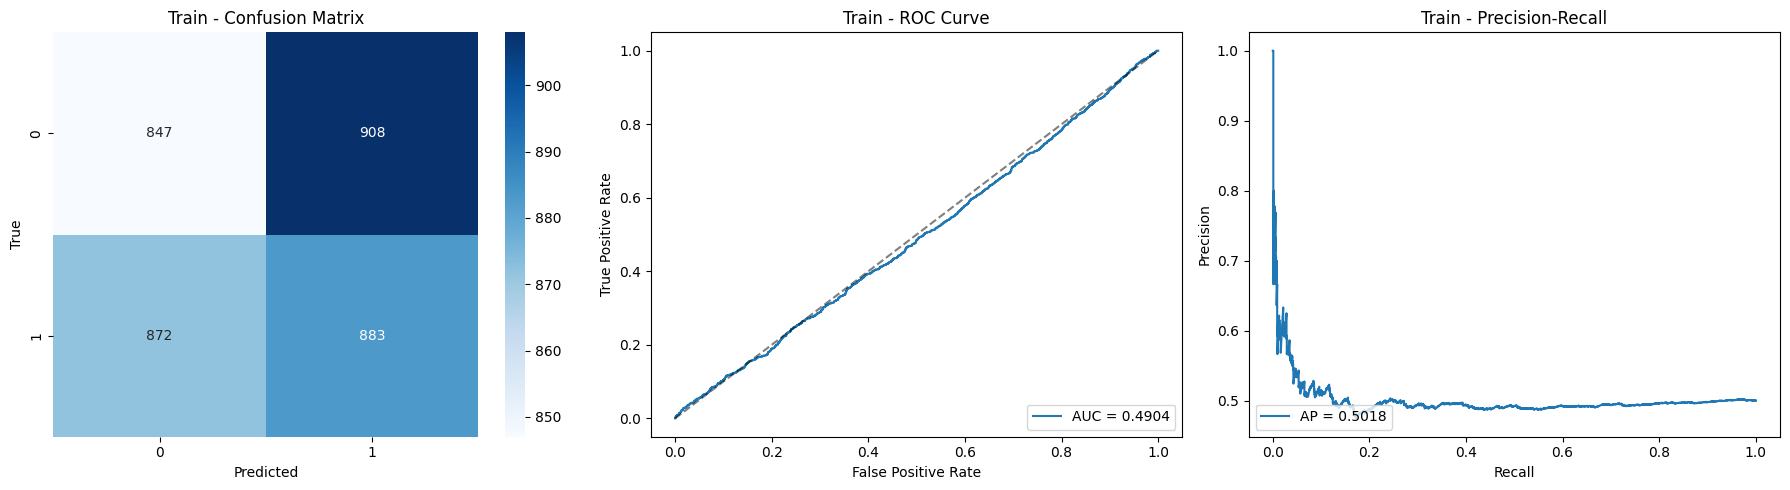

[TRAIN] accuracy=0.4929 logloss=0.693151
              precision    recall  f1-score   support

           0     0.4927    0.4826    0.4876      1755
           1     0.4930    0.5031    0.4980      1755

    accuracy                         0.4929      3510
   macro avg     0.4929    0.4929    0.4928      3510
weighted avg     0.4929    0.4929    0.4928      3510



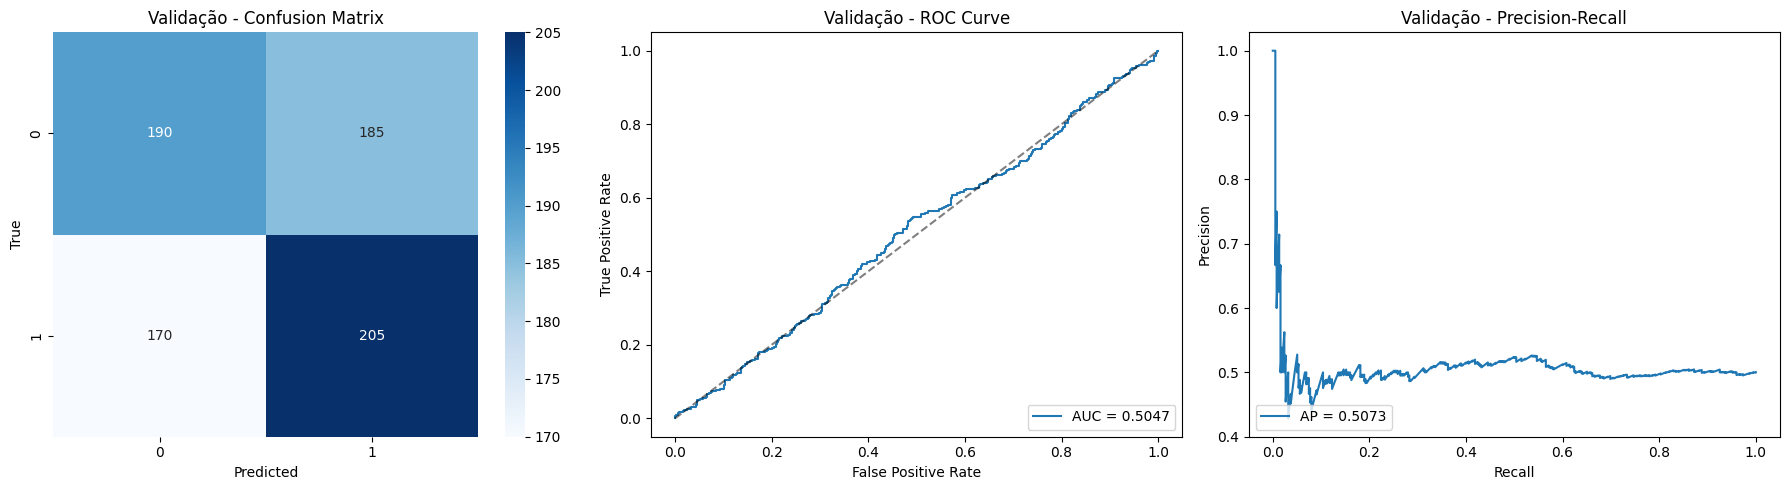

[VAL]   accuracy=0.5267 logloss=0.693145
              precision    recall  f1-score   support

           0     0.5278    0.5067    0.5170       375
           1     0.5256    0.5467    0.5359       375

    accuracy                         0.5267       750
   macro avg     0.5267    0.5267    0.5265       750
weighted avg     0.5267    0.5267    0.5265       750



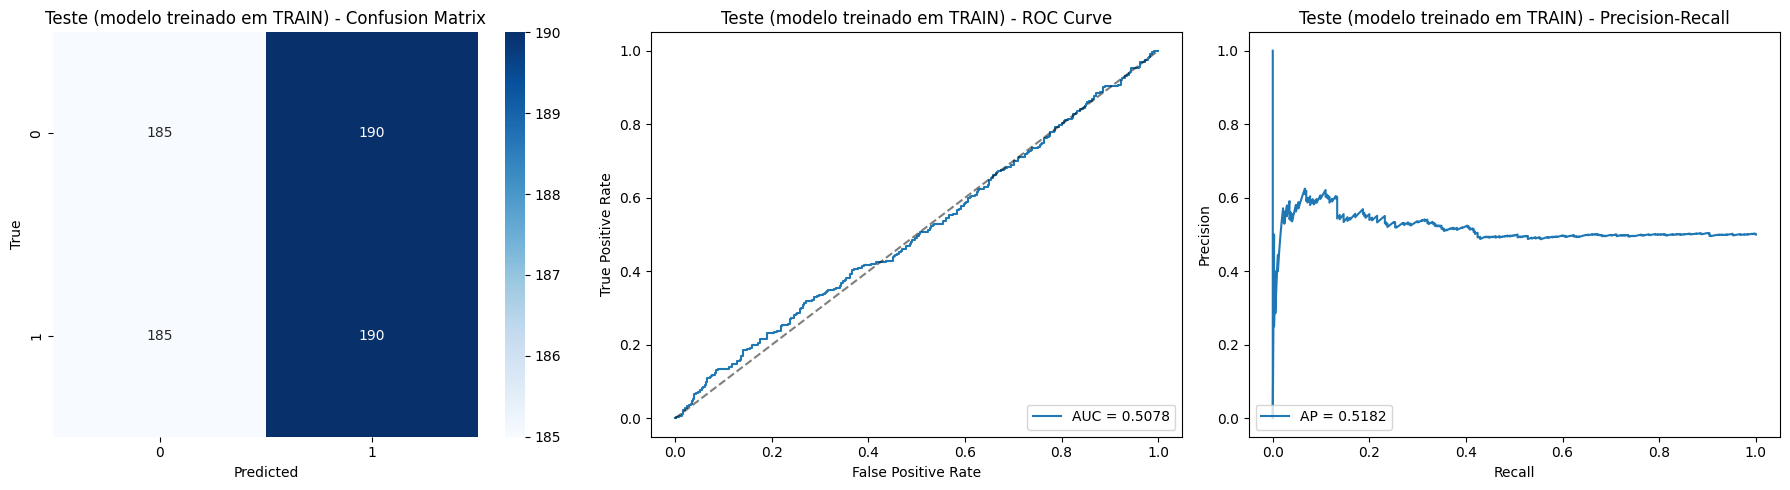

[TEST]  accuracy=0.5000 logloss=0.693139
              precision    recall  f1-score   support

           0     0.5000    0.4933    0.4966       375
           1     0.5000    0.5067    0.5033       375

    accuracy                         0.5000       750
   macro avg     0.5000    0.5000    0.5000       750
weighted avg     0.5000    0.5000    0.5000       750


Avaliação FINAL no TESTE (modelo treinado em TRAIN+VAL):


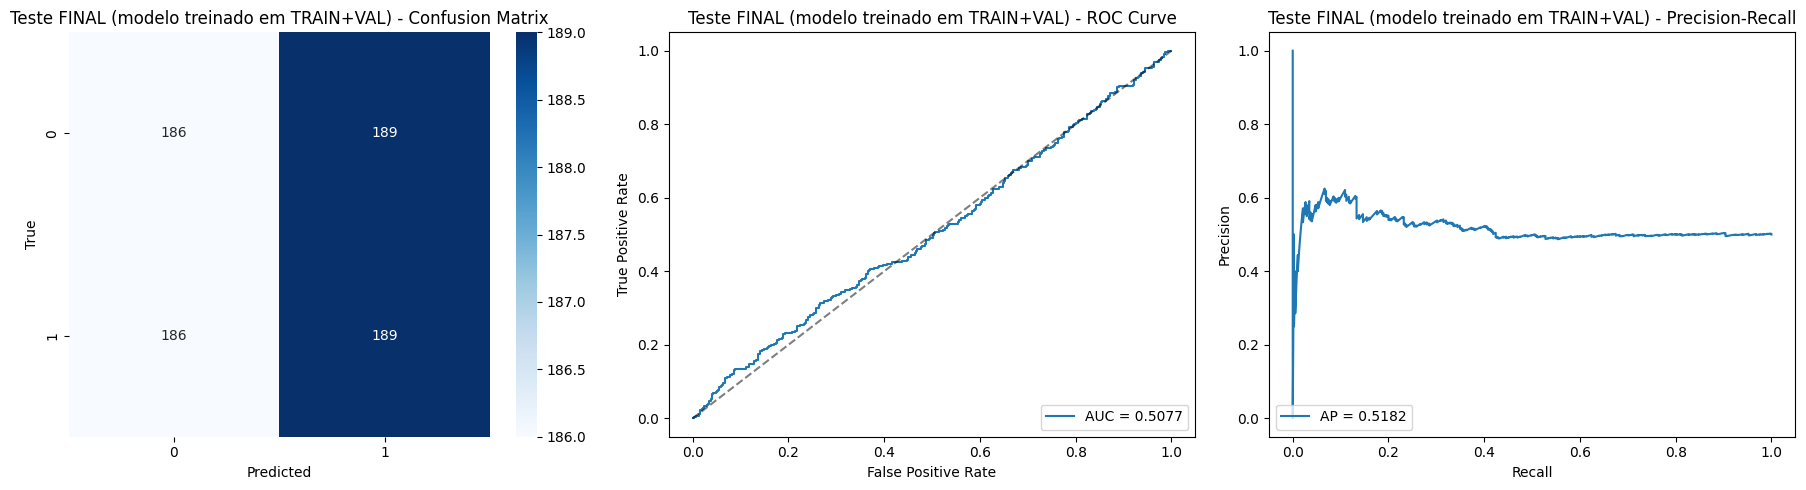

[FINAL TEST] accuracy=0.5000 logloss=0.693139
              precision    recall  f1-score   support

           0     0.5000    0.4960    0.4980       375
           1     0.5000    0.5040    0.5020       375

    accuracy                         0.5000       750
   macro avg     0.5000    0.5000    0.5000       750
weighted avg     0.5000    0.5000    0.5000       750



In [7]:
from train_mlp_cv_optuna import run_training

results = run_training(
    X, y,
    n_trials=10,
    random_state=42,
    cv_folds=4,
    verbose=True,
    # Optional persistence (uncomment to save):
    save_best_model_path="artifacts/best_model_train.pkl",
    save_final_model_path="artifacts/final_model_trainval.pkl",
    save_study_path="artifacts/optuna_study.pkl",
)